In [16]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.optimizers import SGD
from keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


In [17]:
def load_newts(do_min_max=False):
    data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00528/dataset.csv', delimiter=';', skiprows=1)
    xvals_raw = data.drop(['ID', 'Green frogs', 'Brown frogs', 'Common toad', 'Tree frog', 'Common newt', 'Great crested newt', 'Fire-bellied toad'], axis=1)
    xvals = pd.get_dummies(xvals_raw, columns=['Motorway', 'TR', 'VR', 'SUR1', 'SUR2', 'SUR3', 'UR', 'FR', 'MR', 'CR'])
    yvals = data['Fire-bellied toad']

    if (do_min_max):
        for col in ['SR', 'NR', 'TR', 'VR', 'OR', 'RR', 'BR']:
            xvals_raw[col] = (xvals_raw[col] - xvals_raw[col].min())/(xvals_raw[col].max() - xvals_raw[col].min())
    xvals = pd.get_dummies(xvals_raw, columns=['Motorway', 'TR', 'VR', 'SUR1', 'SUR2', 'SUR3', 'UR', 'FR', 'MR', 'CR'])
    return xvals, yvals

In [18]:
def plot_svms(df1, df2, df3):
    # Drop the runtime column
    df1 = df1.drop('Runtime', axis=1)
    df2 = df2.drop('Runtime', axis=1)
    df3 = df3.drop('Runtime', axis=1)
    plt.figure(figsize=(8,6))

    # log scale for the x-axis
    plt.xscale('log')

    # label the axes
    plt.xlabel('c and gamma (log scale)')
    plt.ylabel('F1 score')
    
    # plot the data frames on the same figure
    plt.plot(df1.index, df1['F1 score (train)'], '-', label='Linear SVM (train)', color='red')
    plt.plot(df1.index, df1['F1 score (CV)'], '--', label='Linear SVM (CV)', color='red')
    
    plt.plot(df2.index, df2['F1 score (train)'], '-', label='Slack SVM (train)', color='green')
    plt.plot(df2.index, df2['F1 score (CV)'], '--', label='Slack SVM (CV)', color='green')
    
    plt.plot(df3.index, df3['F1 score (train)'], '-', label='Learning SVM (train)', color='blue')
    plt.plot(df3.index, df3['F1 score (CV)'], '--', label='Learning SVM (CV)', color='blue')
    
    # add legend
    plt.legend(loc='best')

    plt.show()


In [19]:
def plot_svms(df1, df2, df3):
    # Drop the runtime column
    df1 = df1.drop('Runtime', axis=1)
    df2 = df2.drop('Runtime', axis=1)
    df3 = df3.drop('Runtime', axis=1)
    plt.figure(figsize=(8,6))

    ax1 = df1.plot(kind='line', style=['-', '--'], color=['red', 'red'])

    # Plot second dataframe with solid line and blue color for F1 score (train), and dashed line and light blue color for F1 score (CV)
    df2.plot(kind='line', style=['-', '--'], ax=ax1, color=['blue', 'blue'])

    # Plot third dataframe with solid line and green color for F1 score (train), and dashed line and light green color for F1 score (CV)
    df3.plot(kind='line', style=['-', '--'], ax=ax1, color=['green', 'green'])

    # log scale for the x-axis
    plt.xscale('log')

    # label the axes
    plt.xlabel('c and gamma (log scale)')
    plt.ylabel('F1 score')
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines

    blue_square = mlines.Line2D([], [], color='blue', marker='s', markersize=8, label='Linear SVM')
    red_square = mlines.Line2D([], [], color='red', marker='s', markersize=8, label='Slack SVM')
    green_square = mlines.Line2D([], [], color='green', marker='s', markersize=8, label='Learning SVM')

    solid_line = mlines.Line2D([], [], color='black', linestyle='-', label='F1 Complete Data')
    dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='F1 Cross-Validation')

    plt.legend(handles=[blue_square, red_square, green_square, solid_line, dashed_line], loc='best')

    plt.show()




In [20]:
def LinearSVM(xvals, yvals, c_values= [0.0001, 0.001, 0.01, .1, 1, 10]):
    """
    Applies the LinearSVM with various values for the slack variable parameter to achieve
    the strongest performance on the training data. For each value of the slack variable, 
    the function obtains two scores - the score on the training set when training on the 
    complete data, and the result of a k-fold evaluation step. 

    Parameters:
    xvals (pandas.DataFrame): The feature matrix
    yvals (pandas.Series): The target vector
    k_fold (int): The number of folds to use for cross-validation (default=5)

    Returns:
    dict: A dictionary with keys as slack variable parameter values and values as tuples 
          of the form (training_score, cross_val_score)
    """
    results = {}
    # c_values = [0.0001, 0.001, 0.01, .1, 1, 10]

    for c in c_values: 
        start = time.time()
        # create an instance of the LinearSVC classifier with the current C value
        clf = LinearSVC(C=c, dual=False, max_iter=10000)  
        clf.fit(xvals, yvals)
        y_pred_train = clf.predict(xvals)
        y_pred_train = np.where(y_pred_train >= 0.5, 1, 0) 
        train_score = f1_score(yvals, y_pred_train)     
        # fit the classifier on the training data

        # calculate the training accuracy

        # store the training and cross-validation scores in the results dictionary
        cross_val= cross_val_score(clf, xvals, yvals, cv=5, scoring='f1_macro').mean()

        runtime = time.time() - start
        results[c] = {'F1 score (train)': round(train_score, 3), 'F1 score (CV)': round(cross_val, 3), 'Runtime': (runtime)}
    df = pd.DataFrame.from_dict(results, orient='index')
    df.index.rename('slack variable', inplace=True)
    df.columns.name = 'Linear SVM'

    #     # plot the F1 training and cross-validation scores for each value of the slack variable
    # plt.plot(df.index, df['F1 score (train)'], label='F1 score (train)')
    # plt.plot(df.index, df['F1 score (CV)'], label='F1 score (CV)')
    # plt.xscale('log')
    # plt.xlabel('Slack variable (log scale)')
    # plt.ylabel('F1 score')
    # plt.legend()
    # plt.title("Linear SVM")
    # plt.show()

    return df


In [21]:
def RBF_Slack_SVM(xvals, yvals, c_values = [0.001, 0.01, 0.1, 1, 10, 100,1000] , k_fold=5):
    """
    Applies the kernel SVM with various values for the slack variable parameter to achieve
    the strongest performance on the training data. For each value of the slack variable, 
    the function obtains two scores - the score on the training set when training on the 
    complete data, and the result of a k-fold evaluation step. 

    Parameters:
    xvals (pandas.DataFrame): The feature matrix
    yvals (pandas.Series): The target vector
    c_values (list of floats): The slack variable parameter values to try
    k_fold (int): The number of folds to use for cross-validation (default=5)

    Returns:
    dict: A dictionary with keys as slack variable parameter values and values as tuples 
          of the form (training_score, cross_val_score)
    """
    results = {}

    for c in c_values:
        start = time.time()

        # create an instance of the SVC classifier with a radial basis function (RBF) kernel
        clf = SVC(C=c, kernel='rbf', gamma='scale')
        
        # fit the classifier on the training data
        clf.fit(xvals, yvals)

        # calculate the training accuracy
        y_pred_train = clf.predict(xvals)
        # y_pred_train = np.where(y_pred_train >= 0.5, 1, 0) 
        train_score = f1_score(yvals, y_pred_train)  

        # perform k-fold cross-validation to get the cross-validation accuracy
        kfold = KFold(n_splits=k_fold)
        cross_val_scores = []
        for train_index, test_index in kfold.split(xvals): # for each fold
            clf.fit(xvals.iloc[train_index], yvals.iloc[train_index])
            y_pred_test = clf.predict(xvals.iloc[test_index]) # evaluate the model on the test data
            score = f1_score(yvals.iloc[test_index], y_pred_test) # add the F1 score from this fold to the total
            cross_val_scores.append(score)
        cross_val_score = np.mean(cross_val_scores)
        runtime = time.time() - start
        results[c] = {'F1 score (train)': round(train_score, 3), 'F1 score (CV)': round(cross_val_score, 3), 'Runtime': (runtime)}
        
    df = pd.DataFrame.from_dict(results, orient='index')
    df.index.rename('slack variable', inplace=True)
    df.columns.name = 'Slack RBF-SVM'
    return df



In [22]:
def RBF_Learn_SVM(xvals, yvals, gamma_values= [0.001, 0.01, 0.1, 1, 10, 100], k_fold=5):
    """
    Applies the kernel SVM with a fixed slack variable parameter and various values for
    the scale parameter of the radial basis function (RBF) kernel to achieve the strongest
    performance on the training data. For each value of the scale parameter, the function
    obtains two scores - the score on the training set when training on the complete data,
    and the result of a k-fold evaluation step. 

    Parameters:
    xvals (pandas.DataFrame): The feature matrix
    yvals (pandas.Series): The target vector
    gamma_values (list of floats): The scale parameter values to try
    k_fold (int): The number of folds to use for cross-validation (default=5)

    Returns:
    dict: A dictionary with keys as scale parameter values and values as tuples 
          of the form (training_score, cross_val_score)
    """
    results = {}

    for gamma in gamma_values:
        start = time.time()
        # create an instance of the SVC classifier with a radial basis function (RBF) kernel
        clf = SVC(kernel='rbf', gamma=gamma)
        
        # fit the classifier on the training data
        clf.fit(xvals, yvals)
        # predict the labels for the training data
        y_pred_train = clf.predict(xvals)
        # calculate the F1 score for the training data
        train_score = f1_score(yvals, y_pred_train)  

        cross_val= cross_val_score(clf, xvals, yvals, cv=5, scoring='f1_macro').mean()

        runtime = time.time() - start


        results[gamma] = {'F1 score (train)': round(train_score, 3), 'F1 score (CV)': round(cross_val, 3), 'Runtime': (runtime)}

    df = pd.DataFrame.from_dict(results, orient='index')
    
    df.index.rename('learing rate', inplace=True)
    df.columns.name = 'Learning RBF-SVM'

    return df


In [23]:
def createMLP(xvals, yvals, hidden_units=10, activation='sigmoid', optimizer='adam', learning_rate = 0.001):

        def f1_scoreK(y_true, y_pred):
                y_true = y_true.ravel()
                y_pred = y_pred.ravel()
                y_pred = K.round(y_pred)
                tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
                fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
                fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
                p = tp / (tp + fp + K.epsilon())
                r = tp / (tp + fn + K.epsilon())
                f1score = 2*p*r / (p+r+K.epsilon())
                return float(f1score)
            # Set the optimizer, learning rate, and loss function
        if optimizer == 'adam':
                opt = Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
                opt = SGD(learning_rate=learning_rate)
        else:
                opt = optimizer
        model = Sequential() # creates a new neural network model object using the Keras Sequential API
        model.add(Dense(hidden_units, input_dim=xvals.shape[1], activation=activation)) # adds a hidden layer with k (10) units 
        model.add(Dense(1, activation='sigmoid')) # adds an output layer with 1 unit for the binary classification output 
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1_scoreK]) # compiles the model using the binary cross-entropy loss function, the Adam optimizer, and the F1 score metric
        model.fit(xvals, yvals, epochs=150, batch_size=15, verbose=0) 
        return model

In [24]:
def mlp(xvals, yvals, hidden_units=20, activation='sigmoid', optimizer='adam',learning_rates = [0.0002,0.0005, 0.001, 0.00146, 0.01, 0.1, 1]):

    # Define a range of learning rates to try
    # learning_rates = [0.0002,0.0005, 0.001, 0.00146, 0.01, 0.1, 1] # learning rate is the step size for gradient descent

    # Train the model with each learning rate and evaluate on the training data and k-fold cross-validation
    results = {} # dictionary to store the training and cross-validation scores for each learning rate
    best_learning = 0
    best_score = 0

    for learning_rate in learning_rates: 
        start = time.time()

        # Initialize the model
        mlp = createMLP(xvals, yvals, hidden_units, activation, optimizer, learning_rate)
        # Get F1 score on training data
        scores = mlp.evaluate(xvals, yvals)
        accuracy = scores[1]
        train_score = scores[2]


        if train_score > best_score:
            best_score = train_score
            best_learning = learning_rate        
        runtime = time.time() - start

        # Add the F1 scores to the dictionary
        results[learning_rate] = {'F1 score': round(train_score, 3), 'Runtime': (runtime), 'Best F1 score': (best_learning)}
        # What is F1 score? It is the score that combines precision and recall into one metric (harmonic mean of precision and recall)
        df = pd.DataFrame.from_dict(results, orient='index')
        df.index.rename('learning rate', inplace=True)
        df.columns.name = 'MLP Learning'
    plt.plot(df.index, df['F1 score'], label='F1 score')
    # plt.plot(df.index, df['F1 score (CV)'], label='F1 score (CV)')
    plt.xscale('log')
    plt.xlabel('learning rate (log scale)')
    plt.ylabel('F1 score')
    plt.legend()
    plt.title("MLP with Various Learning Rates")
    plt.show()

    return df


In [25]:
def mlp_sweep(xvals, yvals, k=5, hidden_units=20, activation='sigmoid', optimizer='adam',learning_rate = 0.01):


    # Train the model with each learning rate and evaluate on the training data and k-fold cross-validation
    results = {} # dictionary to store the training and cross-validation scores for each learning rate
    for units in range(1, hidden_units+1):
        start = time.time()

        # Initialize the model
        mlp = createMLP(xvals, yvals, units, activation, optimizer, learning_rate)
        # Get F1 score on training data
        scores = mlp.evaluate(xvals, yvals)
        train_score = scores[2]
        
        kfold = KFold(n_splits=k, shuffle=True, random_state=1)
        cross_val_scores = []
        
        for train_idx, val_idx in kfold.split(xvals):
            xTrain, xVal = xvals.iloc[train_idx], xvals.iloc[val_idx]
            yTrain, yVal = yvals.iloc[train_idx], yvals.iloc[val_idx]
            # Initialize the model
            new_mlp = createMLP(xTrain, yTrain, units, activation, optimizer, learning_rate)
            # Get F1 score on training data
            scores = new_mlp.evaluate(xVal, yVal)
            f1_score = scores[2]
            cross_val_scores.append(f1_score)
        cross_val = np.mean(cross_val_scores)
        runtime = time.time() - start

        # Add the F1 scores to the dictionary
        results[units] = {'F1 score (train)': round(train_score, 3), 'F1 score (CV)': round(cross_val, 3), 'Runtime': (runtime)}
        # What is F1 score? It is the score that combines precision and recall into one metric (harmonic mean of precision and recall)
        df = pd.DataFrame.from_dict(results, orient='index')
        df.index.rename('learning rate', inplace=True)
        df.columns.name = 'MLP Learning'
    plt.plot(df.index, df['F1 score (train)'], label='F1 score (train)')
    plt.plot(df.index, df['F1 score (CV)'], label='F1 score (CV)')
    plt.xlabel('Hidden Units')
    plt.ylabel('F1 score')
    plt.legend()
    plt.title("MLP with Various Hidden Units")
    plt.show()

    return df


In [26]:
xvals, yvals = load_newts(True)

In [27]:
linearSVM = LinearSVM(xvals, yvals, c_values= [0.001, 0.01, 0.1, 1, 10, 100])
slack_SVM = RBF_Slack_SVM(xvals, yvals, c_values= [0.001, 0.01, 0.1, 1, 10, 100], k_fold=5)
learnSVM=RBF_Learn_SVM(xvals, yvals, gamma_values= [0.001, 0.01, 0.1, 1, 10, 100], k_fold=5)

<Figure size 800x600 with 0 Axes>

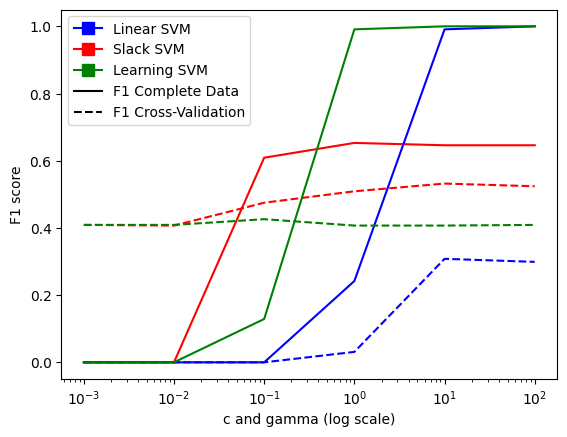

In [28]:
plot_svms(linearSVM, slack_SVM, learnSVM)

6/6 [==============================] - 0s 2ms/step - loss: 0.6369 - accuracy: 0.6931 - f1_scoreK: 0.0000e+00


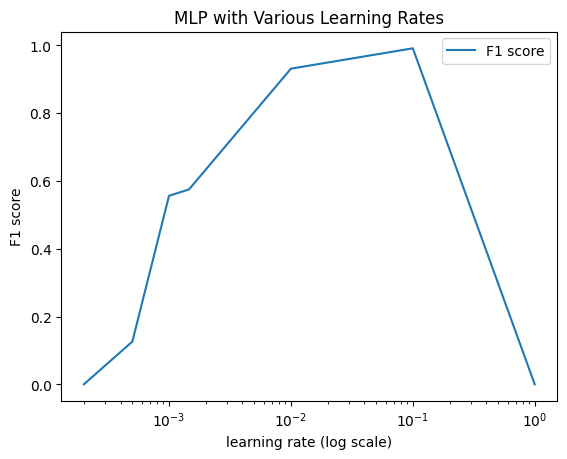

In [29]:
mlp_ = mlp(xvals, yvals, hidden_units=10, activation='sigmoid', optimizer='adam')

In [30]:
mlp_sweep_ = mlp_sweep(xvals, yvals, k=10, hidden_units=20, activation='sigmoid', optimizer='adam')

In [31]:
linearSVM

Linear SVM,F1 score (train),F1 score (CV),Runtime
slack variable,,,
0.001,0.000,0.409,0.064569
0.010,0.000,0.407,0.062713
0.100,0.609,0.475,0.063327
1.000,0.653,0.509,0.057105
10.000,0.646,0.532,0.057717
100.000,0.646,0.524,0.067781


In [40]:
print(linearSVM)

Linear SVM      F1 score (train)  F1 score (CV)   Runtime
slack variable                                           
0.001                      0.000          0.409  0.064569
0.010                      0.000          0.407  0.062713
0.100                      0.609          0.475  0.063327
1.000                      0.653          0.509  0.057105
10.000                     0.646          0.532  0.057717
100.000                    0.646          0.524  0.067781


In [32]:
print(slack_SVM)

Slack RBF-SVM,F1 score (train),F1 score (CV),Runtime
slack variable,,,
0.001,0.000,0.000,0.073696
0.010,0.000,0.000,0.078067
0.100,0.000,0.000,0.074277
1.000,0.242,0.031,0.071227
10.000,0.991,0.308,0.072348
100.000,1.000,0.299,0.069116


In [33]:
print(learnSVM)

Learning RBF-SVM,F1 score (train),F1 score (CV),Runtime
learing rate,,,
0.001,0.000,0.409,0.071946
0.010,0.000,0.409,0.066441
0.100,0.129,0.426,0.225660
1.000,0.991,0.407,0.308802
10.000,1.000,0.407,0.186618
100.000,1.000,0.409,0.102063


In [42]:
print(mlp_)

MLP Learning,F1 score,Runtime,Best F1 score
learning rate,,,
0.00020,0.000,10.230741,0.00000
0.00050,0.126,6.484745,0.00050
0.00100,0.556,9.044416,0.00100
0.00146,0.575,6.097567,0.00146
0.01000,0.931,11.378672,0.01000
0.10000,0.991,4.925044,0.10000
1.00000,0.000,4.913407,0.10000


In [35]:
print(mlp_sweep_)